In [73]:
import os
import cv2
import numpy as np
import torch
import torch.optim as optim
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import torchvision.models as models
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import nest_asyncio
from fastapi import FastAPI, File, UploadFile
from fastapi.responses import JSONResponse
from io import BytesIO
import uvicorn
from collections import Counter

nest_asyncio.apply()

app = FastAPI()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [74]:
folder_path = "C:/Users/manan/Downloads/project2/dataset"

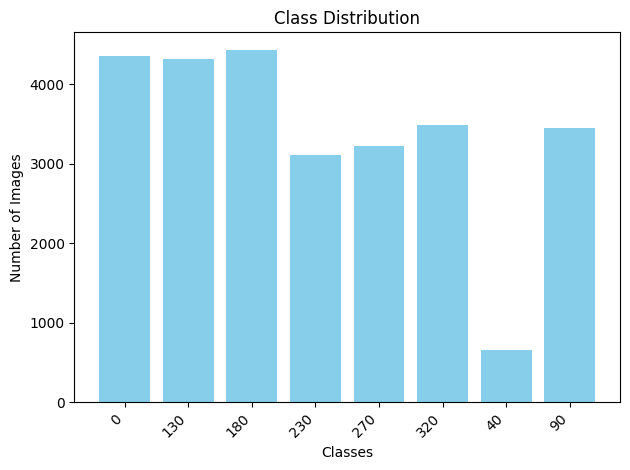

In [75]:
classes = [name for name in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, name))]
class_counts = Counter({cls: len(os.listdir(os.path.join(folder_path, cls))) for cls in classes})

# Plotting
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [76]:
image = "C:/Users/manan/Downloads/project2/dataset/40/443638.jpeg"
image_load = cv2.imread(image)
print(image_load.shape)

(192, 256, 3)


In [77]:
transform = {
    'train': transforms.Compose([
        transforms.CenterCrop((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),  
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop((224, 224)),  
        transforms.ToTensor(),  
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}


In [78]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.root_dir = root_dir
        self.transform = transform
        self.image_label_mapping = []
        self.class_to_idx = self._find_classes()

        # Create image-label mapping
        for class_name, class_idx in self.class_to_idx.items():
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    if os.path.isfile(img_path):
                        self.image_label_mapping.append((img_path, class_idx))

    def _find_classes(self):
        classes = [d for d in os.listdir(self.root_dir) if os.path.isdir(os.path.join(self.root_dir, d))]
        classes.sort()  # Sort to ensure consistent ordering
        return {class_name: idx for idx, class_name in enumerate(classes)}

    def __len__(self):
        return len(self.image_label_mapping)

    def __getitem__(self, idx):
        img_path, label = self.image_label_mapping[idx]
        image = cv2.imread(img_path)
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        # image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        # print(image)
        # print(label)
        return image, label

In [79]:
dataset = CustomDataset(folder_path,transform=None)
print("Class to Index Mapping:")
for class_name, class_idx in dataset.class_to_idx.items():
    print(f"Class Name: {class_name}, Class Index: {class_idx}")
# print(len(dataset.class_to_idx.items()))

Class to Index Mapping:
Class Name: 0, Class Index: 0
Class Name: 130, Class Index: 1
Class Name: 180, Class Index: 2
Class Name: 230, Class Index: 3
Class Name: 270, Class Index: 4
Class Name: 320, Class Index: 5
Class Name: 40, Class Index: 6
Class Name: 90, Class Index: 7


In [80]:
full_dataset = CustomDataset(folder_path,transform = None)
print(len(full_dataset))
# for idx in range(5):
#     image, label = dataset[idx]
#     print(f"image: {image}")
#     print(f"Label: {label}")

27042


In [81]:
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_dataset.dataset.transform = transform['train']
val_dataset.dataset.transform = transform['val']
test_dataset.dataset.transform = transform['val']

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Example: Print dataset sizes
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 18929
Validation size: 4056
Test size: 4057


In [82]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_features = model.fc.in_features
num_classes = len(dataset.class_to_idx.items())
model.fc = torch.nn.Linear(num_features,num_classes)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.001)

In [83]:
def train_model(model, train_loader, criterion, optimizer, device,):
    train_loss, train_acc = 0.0, 0.0
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
        _, predicted = outputs.max(1)  # Get the index of the max log-probability
        total += labels.size(0)
        train_running_correct += predicted.eq(labels).sum().item()
    # scheduler.step()
    train_loss = train_running_loss / len(train_loader)
    train_acc = 100 * train_running_correct / total
    return train_loss, train_acc

def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            val_running_correct += predicted.eq(labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_acc = 100 * val_running_correct / total
    return val_loss, val_acc

class SaveBestModel:
   
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'best_model.pth')

In [84]:
save_best_model = SaveBestModel()
train_loss_list, valid_loss_list = [], []
train_acc_list, valid_acc_list = [],[]
num_epochs=2
# Training and Validation
for epoch in range(num_epochs):
    print(f"[INFO]: Epoch {epoch+1} of {num_epochs}")
    
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    valid_loss, valid_acc = validate_model(model, val_loader, criterion, device)
    
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    train_acc_list.append(train_acc)
    valid_acc_list.append(valid_acc)

    print(f"Training loss: {train_loss:.3f}, Training acc: {train_acc:.3f}")
    print(f"Validation loss: {valid_loss:.3f}, Validation acc: {valid_acc:.3f}")
    
    save_best_model(valid_loss, epoch, model, optimizer, criterion) #save best weights
    
    print('-'*50)

[INFO]: Epoch 1 of 2
Training loss: 0.260, Training acc: 91.827
Validation loss: 0.300, Validation acc: 91.050

Best validation loss: 0.299547074875963

Saving best model for epoch: 1

--------------------------------------------------
[INFO]: Epoch 2 of 2
Training loss: 0.184, Training acc: 94.231
Validation loss: 0.191, Validation acc: 94.132

Best validation loss: 0.1913596202480042

Saving best model for epoch: 2

--------------------------------------------------


In [ ]:
@app.get("/evaluate")
async def evaluate_model():
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total

    # Return results as JSON
    return {
        "test_loss": round(test_loss, 4),
        "test_accuracy": round(test_accuracy, 2),
        "total_samples": total,
        "correct_predictions": correct,
        "all_labels": all_labels,
        "all_predictions": all_predictions
    }

if __name__ == "__main__":
    import uvicorn
    uvicorn.run(app, host="0.0.0.0", port=8000)

INFO:     Started server process [22704]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:65378 - "GET / HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:65378 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:65391 - "GET / HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:65391 - "GET /favicon.ico HTTP/1.1" 404 Not Found
